<font size="+3"><strong>3.4. ARMA Models</strong></font>

In [2]:
import inspect
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

In [3]:
VimeoVideo("665851728", h="95c59d2805", width=600)

<div style="padding: 1em; border: 1px solid #f0ad4e; border-left: 6px solid #f0ad4e; background-color: #fcf8e3; color: #8a6d3b; border-radius: 4px;">

<strong>🛠️ Instruction:</strong> Locate the IP address of the machine running MongoDB and assign it to the variable <code>host</code>. Make sure to use a <strong>string</strong> (i.e., wrap the IP in quotes).<br><br>

<strong>⚠️ Note:</strong> The IP address is <strong>dynamic</strong> — it may change every time you start the lab. Always check the current IP before proceeding.

</div>

<img src="../images/mongo_ip.png" alt="MongoDB" width="600"/>


# Prepare Data

## Import

**Task 3.4.1:** Create a client to connect to the MongoDB server running at `host` on port `27017`, then assign the `"air-quality"` database to `db`, and the `"nairobi"` collection to `nairobi`.

- [<span id='technique'>Create a client object for a <span id='tool'>MongoDB</span> instance.](../%40textbook/11-databases-mongodb.ipynb#Servers-and-Clients) 
- [<span id='technique'>Access a database using <span id='tool'>PyMongo.](../%40textbook/11-databases-mongodb.ipynb#Servers-and-Clients)
- [<span id='technique'>Access a collection in a database using <span id='tool'>PyMongo.](../%40textbook/11-databases-mongodb.ipynb#Collections)

In [4]:
client = MongoClient(host="192.164.180.2",port=27017)
db = client['air-quality']
nairobi = db["nairobi"]

In [5]:
VimeoVideo("665851670", h="3efc0c20d4", width=600)

**Task 3.4.2:** Change your `wrangle` function so that it has a `resample_rule` argument that allows the user to change the resampling interval. The argument default should be `"1H"`.

- [What's an <span id='term'>argument?](../%40textbook/02-python-advanced.ipynb#Functions)
- [<span id='technique'>Include an argument in a function in <span id='tool'>Python.](../%40textbook/02-python-advanced.ipynb#Functions)

In [6]:
def wrangle(collection,resample_rule="1H"):
    results = collection.find(
        {"metadata.site": 29, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
    )

    # Read results into DataFrame
    df = pd.DataFrame(list(results)).set_index("timestamp")
    df = pd.DataFrame(list(results)).set_index("timestamp")

    # Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

    # Remove outliers
    df = df[df["P2"] < 500]

    # Resample and forward-fill
    y = df["P2"].resample(resample_rule).mean().fillna(method="ffill")

    return y

In [7]:
# Check your work
func_params = set(inspect.signature(wrangle).parameters.keys())
assert func_params == set(
    ["collection", "resample_rule"]
), f"Your function should take two arguments: `'collection'`, `'resample_rule'`. Your function takes the following arguments: {func_params}"

**Task 3.4.3:** Use your wrangle function to read the data from the `nairobi` collection into the Series `y`.

In [8]:
y =wrangle(nairobi,resample_rule="1H")
y.head()
y.shape

ServerSelectionTimeoutError: 192.164.180.2:27017: [Errno 101] Network is unreachable (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms), Timeout: 30s, Topology Description: <TopologyDescription id: 6891e48f209fc7289e452d1d, topology_type: Unknown, servers: [<ServerDescription ('192.164.180.2', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('192.164.180.2:27017: [Errno 101] Network is unreachable (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms)')>]>

In [ ]:
# Check your work
assert isinstance(y, pd.Series), f"`y` should be a Series, not a {type(y)}."
assert len(y) == 2928, f"`y` should have 2,928 observations, not {len(y)}."
assert (
    y.isnull().sum() == 0
), f"There should be no null values in `y`. Your `y` has {y.isnull().sum()} null values."

## Explore

In [20]:
VimeoVideo("665851654", h="687ff8d5ee", width=600)

**Task 3.4.4:** Create an ACF plot for the data in `y`. Be sure to label the x-axis as `"Lag [hours]"` and the y-axis as `"Correlation Coefficient"`.

- [What's an <span id='term'>ACF plot?](../%40textbook/17-ts-core.ipynb#ACF-Plot)
- [<span id='technique'>Create an ACF plot using <span id='tool'>statsmodels](../%40textbook/18-ts-models.ipynb#Creating-an-ACF-Plot)

Text(0, 0.5, 'Correlation Coefficient')

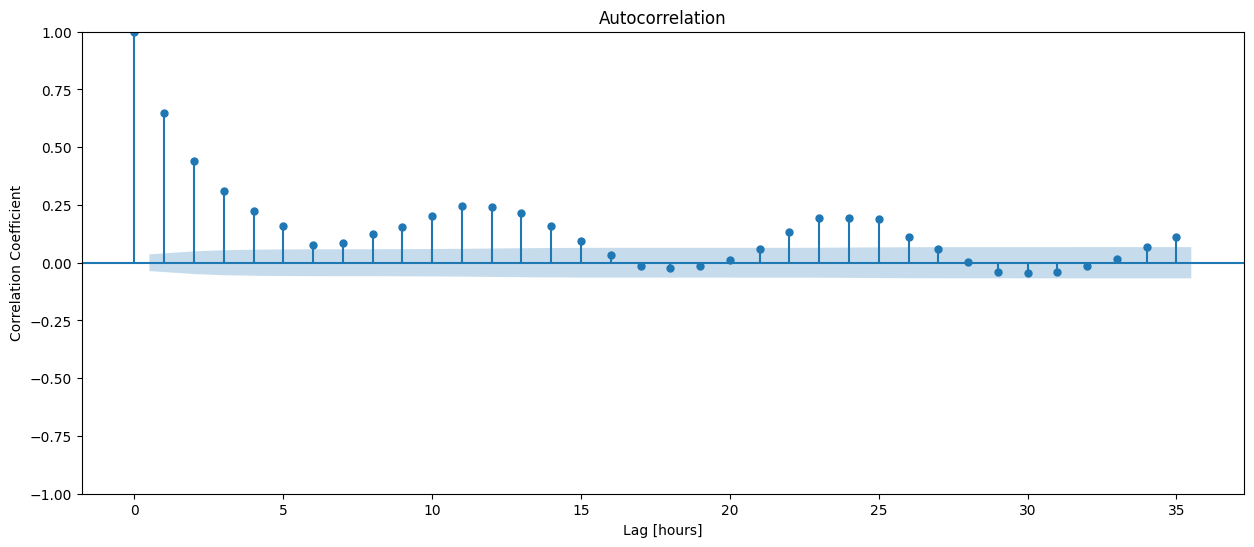

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))

plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")

In [24]:
VimeoVideo("665851644", h="e857f05bfb", width=600)

**Task 3.4.5:** Create an PACF plot for the data in `y`. Be sure to label the x-axis as `"Lag [hours]"` and the y-axis as `"Correlation Coefficient"`.

- [What's a PACF plot?](../%40textbook/17-ts-core.ipynb#PACF-Plot)
- [Create an PACF plot using statsmodels](../%40textbook/18-ts-models.ipynb#Creating-a-PACF-Plot)

Text(0, 0.5, 'Correlation Coefficient')

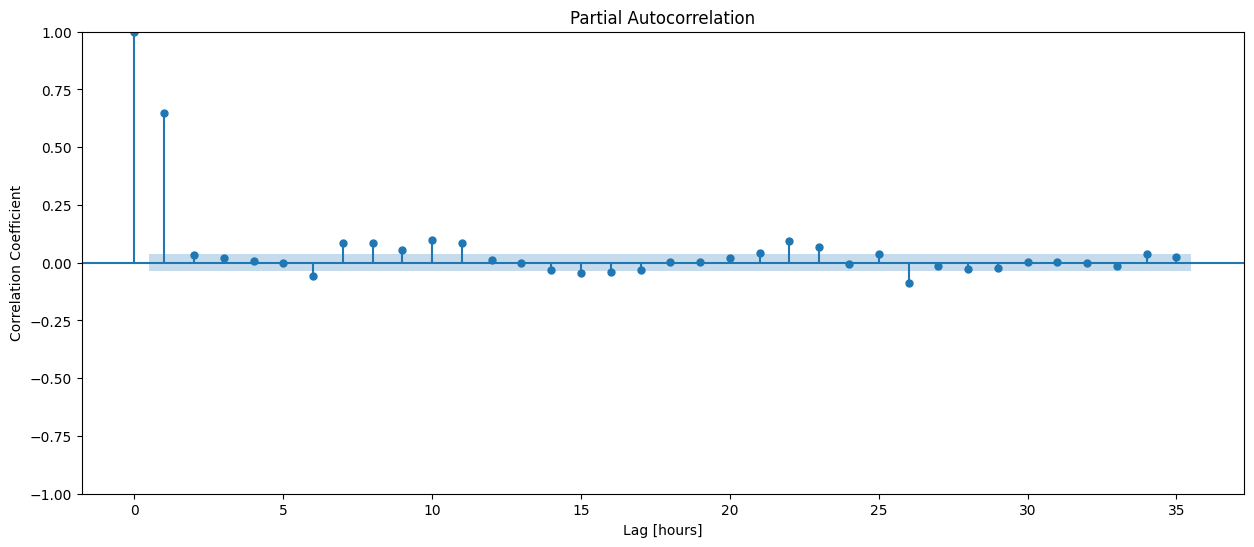

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))

plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")

## Split

**Task 3.4.6:** Create a training set `y_train` that contains only readings from October 2018, and a test set `y_test` that contains readings from November 1, 2018.

- [<span id='technique'>Subset a DataFrame by selecting one or more rows in <span id='tool'>pandas.](../%40textbook/04-pandas-advanced.ipynb#Subsetting-with-Masks)

In [26]:

y_train = y["2018-10"]
y_test = y["2018-11-01"]

In [37]:
# Check your work
assert (
    len(y_train) == 744
), f"`y_train` should have 744 observations, not {len(y_train)}."
assert len(y_test) == 24, f"`y_test` should have 24 observations, not {len(y_test)}."

# Build Model

## Baseline

**Task 3.4.7:** Calculate the baseline mean absolute error for your model.

In [40]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 10.12
Baseline MAE: 4.17


## Iterate

In [41]:
VimeoVideo("665851576", h="36e2dc6269", width=600)

**Task 3.4.8:** Create ranges for possible $p$ and $q$ values. `p_params` should range between 0 and 25, by steps of 8. `q_params` should range between 0 and 3 by steps of 1.

- [What's a <span id='term'>hyperparameter?](../%40textbook/17-ts-core.ipynb#Hyperparameters)
- [What's an <span id='term'>iterator?](../%40textbook/02-python-advanced.ipynb#Iterators-and-Iterables-)
- [<span id='technique'>Create a range in <span id='tool'>Python.](../%40textbook/18-ts-models.ipynb#Hyperparameters)

In [9]:
p_params = range(0,25,8)
q_params = range(0,3,1)


In [45]:
VimeoVideo("665851476", h="d60346ed30", width=600)

**Task 3.4.9:** Complete the code below to train a model with every combination of hyperparameters in `p_params` and `q_params`. Every time the model is trained, the mean absolute error is calculated and then saved to a dictionary. If you're not sure where to start, do the code-along with Nicholas!

- [What's an <span id='term'>ARMA model?](../%40textbook/17-ts-core.ipynb#ARMA-Models)
- [<span id='technique'>Append an item to a list in <span id='tool'>Python.](../%40textbook/01-python-getting-started.ipynb#Appending-Items)
- [<span id='technique'>Calculate the mean absolute error for a list of predictions in <span id='tool'>scikit-learn.](../%40textbook/15-ml-regression.ipynb#Calculating-the-Mean-Absolute-Error-for-a-List-of-Predictions)
- [<span id='technique'>Instantiate a predictor in <span id='tool'>statsmodels.](../%40textbook/18-ts-models.ipynb#Iterating)
- [<span id='technique'>Train a model in <span id='tool'>statsmodels.](../%40textbook/18-ts-models.ipynb#Iterating)
- [<span id='technique'>Write a for loop in <span id='tool'>Python.](../%40textbook/01-python-getting-started.ipynb#Working-with-for-Loops)

In [47]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train,order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train,y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.12 seconds.
Trained ARIMA (0, 0, 1) in 0.05 seconds.
Trained ARIMA (0, 0, 2) in 0.06 seconds.
Trained ARIMA (8, 0, 0) in 0.2 seconds.
Trained ARIMA (8, 0, 1) in 0.69 seconds.
Trained ARIMA (8, 0, 2) in 1.24 seconds.
Trained ARIMA (16, 0, 0) in 0.98 seconds.
Trained ARIMA (16, 0, 1) in 2.79 seconds.
Trained ARIMA (16, 0, 2) in 3.89 seconds.
Trained ARIMA (24, 0, 0) in 5.48 seconds.
Trained ARIMA (24, 0, 1) in 7.27 seconds.
Trained ARIMA (24, 0, 2) in 14.69 seconds.

{0: [4.171460443827197, 3.3506427433167634, 3.1057222588243443], 8: [2.9384480570053584, 2.9149013330115974, 2.9132458963032315], 16: [2.9201084725449653, 2.9294363113458335, 2.9120798462337034], 24: [2.914390327410196, 2.9136013236816525, 2.8979121370798664]}


In [48]:
VimeoVideo("665851464", h="12f4080d0b", width=600)

**Task 3.4.10:** Organize all the MAE's from above in a DataFrame names `mae_df`. Each row represents a possible value for $q$ and each column represents a possible value for $p$. 

- [<span id='technique'>Create a DataFrame from a dictionary using <span id='tool'>pandas.](../%40textbook/03-pandas-getting-started.ipynb#Working-with-DataFrames)

In [50]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,4.1715,2.9384,2.9201,2.9144
1,3.3506,2.9149,2.9294,2.9136
2,3.1057,2.9132,2.9121,2.8979


In [51]:
VimeoVideo("665851453", h="dfd415bc08", width=600)

**Task 3.4.11:** Create heatmap of the values in `mae_grid`. Be sure to label your x-axis `"p values"` and your y-axis `"q values"`. 

- [<span id='technique'>Create a heatmap in <span id='tool'>seaborn.](../%40textbook/09-visualization-seaborn.ipynb#Correlation-Heatmaps)

Ellipsis

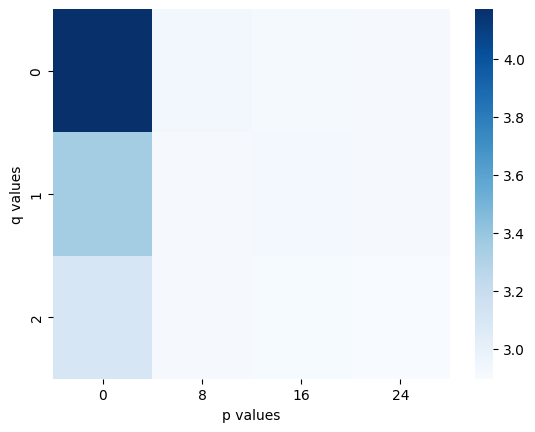

In [54]:
sns.heatmap(mae_df, cmap="Blues")
plt.xlabel("p values")
plt.ylabel("q values")

...

In [55]:
VimeoVideo("665851444", h="8b58161f26", width=600)

**Task 3.4.12:** Use the [`plot_diagnostics`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.plot_diagnostics.html) method to check the residuals for your model. Keep in mind that the plot will represent the residuals from the last model you trained, so make sure it was your best model, too!

- [<span id='technique'>Examine time series model residuals using <span id='tool'>statsmodels.](../%40textbook/18-ts-models.ipynb#Residuals)

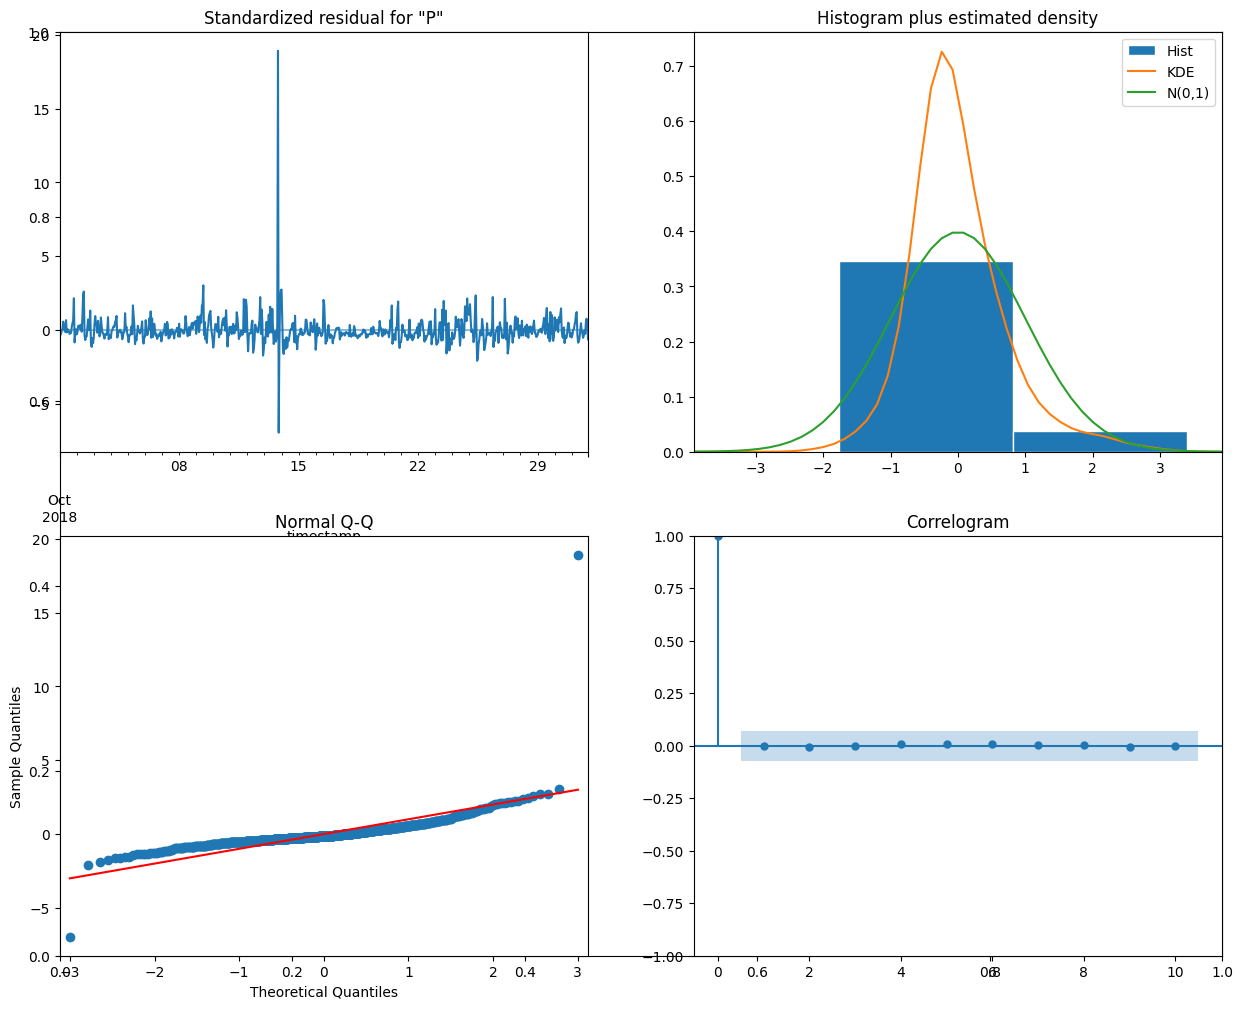

In [57]:
fig, ax = plt.subplots(figsize=(15, 12))

model.plot_diagnostics(fig=fig);

## Evaluate

In [58]:
VimeoVideo("665851439", h="c48d80cdf4", width=600)

**Task 3.4.13:** Complete the code below to perform walk-forward validation for your model for the entire test set `y_test`. Store your model's predictions in the Series `y_pred_wfv`. Choose the values for $p$ and $q$ that best balance model performance and computation time. Remember: This model is going to have to train 24 times before you can see your test MAE!<span style='color: transparent; font-size:1%'>WQU WorldQuant University Applied Data Science Lab QQQQ</span>

In [59]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history,order=(8,0,1)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

In [61]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.67


In [ ]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

# Communicate Results

In [64]:
VimeoVideo("665851423", h="8236ff348f", width=600)

**Task 3.4.14:** First, generate the list of training predictions for your model. Next, create a DataFrame `df_predictions` with the true values `y_test` and your predictions `y_pred_wfv` (don't forget the index). Finally, plot `df_predictions` using plotly express. Make sure that the y-axis is labeled `"P2"`. 

- [<span id='technique'>Generate in-sample predictions for a model in <span id='tool'>statsmodels.](../%40textbook/18-ts-models.ipynb#Iterating)
- [<span id='technique'>Create a DataFrame from a dictionary using <span id='tool'>pandas.](../%40textbook/03-pandas-getting-started.ipynb#Working-with-DataFrames)
- [<span id='technique'>Create a line plot in <span id='tool'>pandas.](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)    

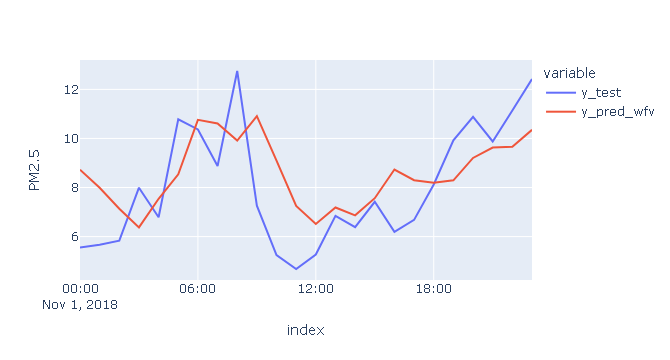

In [71]:
df_predictions = pd.DataFrame({"y_test":y_test,"y_pred_wfv":y_pred_wfv})
fig = px.line(df_predictions,labels={"value":"PM2.5"})
fig.show()

---
Copyright 2023 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
